In [1]:
from data import get_dsb2018_train_files, get_dsb2018_validation_files, get_dsb2018_test_files, fill_label_holes, quantile_normalization
from tifffile import imread

import matplotlib.pyplot as plt
import numpy as np

## Getting lists of input and label files

In [2]:
for name, getter_fn in zip(["train", "val", "test"], [get_dsb2018_train_files, get_dsb2018_validation_files, get_dsb2018_test_files]):
    X, y = getter_fn()
    print(name, len(X), len(y))

train 382 382
val 65 65
test 50 50


In [3]:
X[:3]

[PosixPath('../../data/dsb2018/test/images/0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe.tif'),
 PosixPath('../../data/dsb2018/test/images/0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0.tif'),
 PosixPath('../../data/dsb2018/test/images/1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5.tif')]

In [4]:
y[:3]

[PosixPath('../../data/dsb2018/test/masks/0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe.tif'),
 PosixPath('../../data/dsb2018/test/masks/0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0.tif'),
 PosixPath('../../data/dsb2018/test/masks/1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5.tif')]

## Looking at a single sample of the training data

In [5]:
Xtrain, ytrain = get_dsb2018_train_files()

sidx = 0
image_file, label_file = Xtrain[sidx], ytrain[sidx]
image, label = imread(image_file), imread(label_file)
label_filled = fill_label_holes(label)

In [6]:
print(type(image))
print(type(label))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
for name, sample in zip(["image", "label"], [image, label]):
    print(name, sample.dtype, sample.shape, sample.min(), sample.max())

image uint8 (256, 256) 1 108
label uint16 (256, 256) 0 27


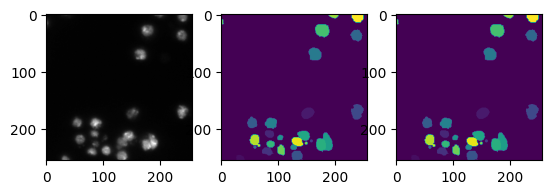

In [8]:
plt.subplot(131)
plt.imshow(image, cmap="gray")

plt.subplot(132)
plt.imshow(label)

plt.subplot(133)
plt.imshow(label_filled)

## Convert the instance label to a binary segmentation mask

As we intend to demonstrate the usage of pytorch, we are simplifying our problem from instance segmentation to semantic segmentation.

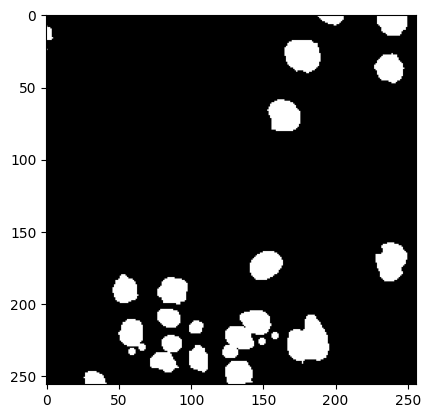

In [9]:
label_binary = np.zeros_like(label_filled)
label_binary[label_filled != 0] = 1

plt.imshow(label_binary, cmap="gray")

## Normalization of the raw image

As neural networks tend to be easier to train when input values are small, we should normalize the pixel intensities from the uint8 range of [0, 255] to floating point values closer to [0, 1].

In [10]:
# similar normalization as shown in stardist (https://github.com/stardist/stardist/blob/master/examples/2D/2_training.ipynb)
image_normalized_noclip = quantile_normalization(
    image,
    quantile_low=0.01,
    quantile_high=0.998,
    clip=False)[0]

image_normalized_clip = quantile_normalization(
    image,
    quantile_low=0.01,
    quantile_high=0.998,
    clip=True)[0]

In [11]:
print(image_normalized_noclip.min(), image_normalized_noclip.max())

print(image_normalized_clip.min(), image_normalized_clip.max())

-0.012658227848101266 1.3417721518987342
0.0 1.0


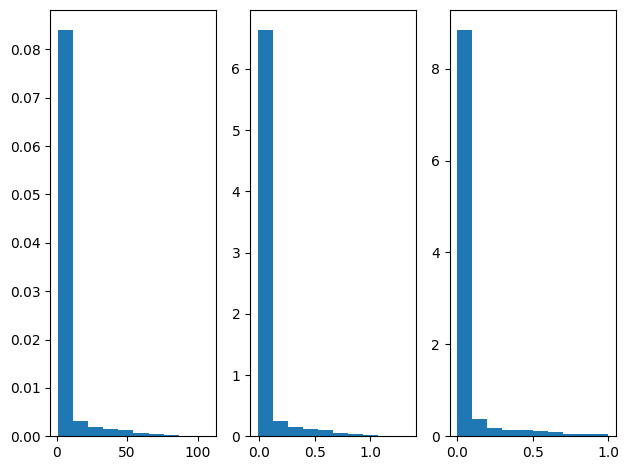

In [12]:
plt.subplot(131)
_ = plt.hist(image.flatten(), density=True)

plt.subplot(132)
_ = plt.hist(image_normalized_noclip.flatten(), density=True)

plt.subplot(133)
_ = plt.hist(image_normalized_clip.flatten(), density=True)

plt.tight_layout()

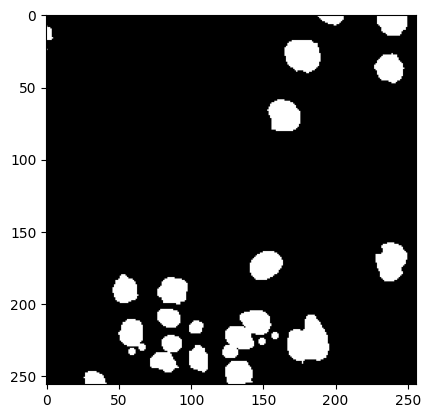

In [13]:
from torchvision import transforms

label_torch = transforms.ToTensor()(label_binary.astype(np.float32))
plt.imshow(label_torch.numpy()[0], cmap="gray")

## We explore the image resolutions on the training data

In [14]:
X = list(map(imread, Xtrain))

In [15]:
X[1].shape

(256, 256)

In [16]:
shapes = [tuple(x.shape) for x in X]

In [17]:
shapes

[(256, 256),
 (256, 256),
 (256, 256),
 (256, 256),
 (360, 360),
 (256, 256),
 (360, 360),
 (360, 360),
 (260, 347),
 (256, 256),
 (256, 256),
 (360, 360),
 (256, 256),
 (256, 256),
 (360, 360),
 (520, 696),
 (360, 360),
 (256, 256),
 (256, 256),
 (256, 256),
 (256, 256),
 (360, 360),
 (256, 256),
 (256, 256),
 (520, 696),
 (360, 360),
 (256, 256),
 (520, 696),
 (256, 256),
 (520, 696),
 (256, 256),
 (256, 256),
 (256, 256),
 (512, 640),
 (360, 360),
 (520, 696),
 (360, 360),
 (256, 256),
 (256, 256),
 (520, 696),
 (256, 256),
 (520, 696),
 (360, 360),
 (256, 256),
 (256, 256),
 (520, 696),
 (360, 360),
 (256, 256),
 (520, 696),
 (256, 256),
 (256, 256),
 (256, 256),
 (520, 696),
 (256, 256),
 (512, 640),
 (512, 640),
 (520, 696),
 (256, 256),
 (256, 256),
 (256, 256),
 (256, 256),
 (256, 256),
 (256, 256),
 (256, 256),
 (256, 256),
 (360, 360),
 (360, 360),
 (360, 360),
 (256, 256),
 (256, 256),
 (512, 640),
 (360, 360),
 (256, 256),
 (520, 696),
 (256, 256),
 (256, 256),
 (256, 256),

In [18]:
unique_shapes = set(shapes)
unique_shapes

{(256, 256), (256, 320), (260, 347), (360, 360), (512, 640), (520, 696)}

In [19]:
counts = {}
for sh in unique_shapes:
    counts[sh] = len([s for s in shapes if s == sh])

counts

{(512, 640): 9,
 (260, 347): 2,
 (360, 360): 71,
 (520, 696): 66,
 (256, 256): 232,
 (256, 320): 2}